In [1]:
import pathlib

import e3psi.models
import hubbardml
from hubbardml import keys, plots, similarities
import numpy as np
import torch

import ignite.metrics.metric

hubbardml.utils.random_seed()

dtype = torch.float32
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device, torch.get_default_dtype()

('cuda', torch.float32)

In [2]:
VALIDATE_PERCENTAGE = 0.2
DATASET = "../data/data_uv_unique_inout_2023_2_8.json"

SAVEFIGS = False
TARGET_PARAM = 'U'
DELTA_LEARNING = False

def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

In [3]:
df = hubbardml.datasets.load(DATASET)

## Input creation

Filter the DF to keep things we want

In [4]:
df = hubbardml.graphs.UGraph.prepare_dataset(df)
species = list(df[keys.ATOM_1_ELEMENT].unique())

graph = hubbardml.graphs.UGraph(species)
print(len(df))

df = similarities.deduplicate(df, graph.get_similarity_frame(df), input_threshold=1e-3)
print(len(df))

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


423


/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


173


## Model creation

In [5]:
model = hubbardml.models.UModel(
    graph,
    feature_irreps="10x0e + 4x2e",
    hidden_layers=2,
    rescaler=hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean"),
    irrep_normalization="norm",
)
model.to(dtype=dtype, device=device)

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


UModel(
  (layers): ModuleList(
    (0): TensorSquare(6x0e+1x2e+1x4e+2x0e+1x1e+1x2e+1x3e+1x4e+1x0e+1x1e+1x2e+1x3e+1x4e+1x5e+1x6e+1x7e+1x8e -> 14x0e+4x2e | 1310 paths | 1310 weights)
    (1): Gate (14x0e+4x2e -> 10x0e+4x2e)
    (2): TensorSquare(10x0e+4x2e -> 14x0e+4x2e | 1110 paths | 1110 weights)
    (3): Gate (14x0e+4x2e -> 10x0e+4x2e)
    (4): TensorSquare(10x0e+4x2e -> 1x0e | 65 paths | 65 weights)
    (5): Rescaler()
  )
)

## Split test/train

In [6]:
hubbardml.datasets.split(df, method='category', frac=0.2, category=[keys.ATOM_1_ELEMENT])

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_1_occs_inv_1,atom_1_occs_inv_2,atom_2_occs_inv_1,atom_2_occs_inv_2,param_delta,species,label,colour,sc_paths,training_label
0,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.24, -0.232, -0.022, -0.012, -0.006], [-0.2...","[[0.3844, 0.013456000000000001, 0.000120999999...","[[1.24, -0.232, -0.022, -0.012, -0.006], [-0.2...","[[0.3844, 0.013456000000000001, 0.000120999999...",10.2709,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
78,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
161,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
237,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.24, -0.232, 0.022, -0.012, 0.006], [-0.232...","[[0.3844, 0.013456000000000001, 0.000120999999...","[[1.24, -0.232, 0.022, -0.012, 0.006], [-0.232...","[[0.3844, 0.013456000000000001, 0.000120999999...",10.2709,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
706,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.2, -0.298, -0.04, -0.025, -0.01], [-0.298,...","[[0.36, 0.022201, 0.0004, 0.000156, 2.5e-05], ...","[[1.2, -0.298, -0.04, -0.025, -0.01], [-0.298,...","[[0.36, 0.022201, 0.0004, 0.000156, 2.5e-05], ...",-0.7733,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95282,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,1,,"[15.4911, 0.0, 0.0, 0.0, 15.491982992699999, 0...",48,iurii,120,1.637239e+09,...,"[[0.904, -0.002999999999999999, 0.0, -0.006, 0...","[[0.167055, -8.8e-05, -8.099999999999999e-05, ...","[[0.904, -0.002999999999999999, 0.0, -0.006, 0...","[[0.167055, -8.8e-05, -8.099999999999999e-05, ...",0.8820,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
98544,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,2,,"[15.4325, 0.0, 0.0, 0.0, 15.4319598625, 0.0, 0...",48,iurii,121,1.637755e+09,...,"[[0.891, -0.006999999999999999, 0.006999999999...","[[0.17700799999999997, -0.00012, -0.00012, 0.0...","[[0.891, -0.006999999999999999, 0.006999999999...","[[0.17700799999999997, -0.00012, -0.00012, 0.0...",-0.0754,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
99337,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,2,,"[15.4325, 0.0, 0.0, 0.0, 15.4319598625, 0.0, 0...",48,iurii,121,1.637755e+09,...,"[[0.898, 0.0, 0.002, 0.005, 0.008], [0.0, 1.07...","[[0.17270100000000002, -0.0001, -9.89999999999...","[[0.898, 0.0, 0.002, 0.005, 0.008], [0.0, 1.07...","[[0.17270100000000002, -0.0001, -9.89999999999...",-0.0833,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
102633,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[[0.8899999999999999, 0.006999999

In [7]:
# Get the indices of the training and validation data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

print(df.loc[train_idx][keys.ATOM_1_ELEMENT].value_counts())
print(df.loc[validate_idx][keys.ATOM_1_ELEMENT].value_counts())

Ni    56
Mn    47
Fe    30
Co     3
Ti     2
Name: atom_1_element, dtype: int64
Ni    14
Mn    12
Fe     8
Co     1
Name: atom_1_element, dtype: int64


In [24]:
trainer = hubbardml.Trainer.from_frame(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn=torch.nn.MSELoss(),
    frame=df,
    target_column=keys.PARAM_DELTA if DELTA_LEARNING else keys.PARAM_OUT,
)

In [76]:
trainer.overfitting_window = 400

trainer.train(
    callback=lambda trainer: print(trainer.status()),
    callback_period=50,
    max_epochs=3_000,
)

epoch: 17000 train: mse 0.05671, valid: mse 0.14073 rmse 0.3751
epoch: 17050 train: mse 0.05483, valid: mse 0.14241 rmse 0.3774
epoch: 17100 train: mse 0.05429, valid: mse 0.14207 rmse 0.3769
epoch: 17150 train: mse 0.05424, valid: mse 0.14217 rmse 0.3771
epoch: 17200 train: mse 0.09659, valid: mse 0.15852 rmse 0.3981
epoch: 17250 train: mse 0.05464, valid: mse 0.14306 rmse 0.3782
epoch: 17300 train: mse 0.05416, valid: mse 0.14167 rmse 0.3764
epoch: 17350 train: mse 0.05407, valid: mse 0.14178 rmse 0.3765
epoch: 17400 train: mse 0.05405, valid: mse 0.14192 rmse 0.3767
epoch: 17450 train: mse 0.05511, valid: mse 0.16709 rmse 0.4088
epoch: 17500 train: mse 0.05638, valid: mse 0.14375 rmse 0.3791
epoch: 17550 train: mse 0.05395, valid: mse 0.14115 rmse 0.3757
epoch: 17600 train: mse 0.05387, valid: mse 0.14143 rmse 0.3761
epoch: 17650 train: mse 0.05386, valid: mse 0.14171 rmse 0.3764
epoch: 17700 train: mse 0.06643, valid: mse 0.16159 rmse 0.4020
epoch: 17750 train: mse 0.05695, valid: 

'max_epochs'

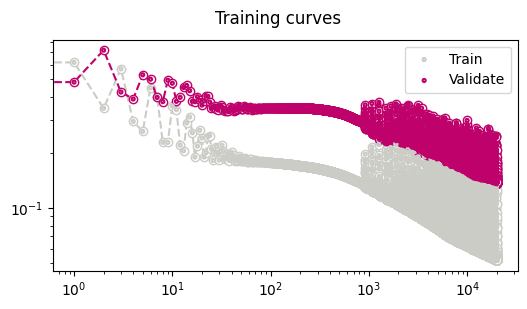

In [77]:
fig = trainer.plot_training_curves();
if SAVEFIGS:
    fig.savefig(plotfile('+U_training'), bbox_inches='tight')
fig.gca().set_xscale("log")

In [78]:
predicted_train = model(trainer.training_data.all_inputs()).detach().cpu().numpy().reshape(-1)
predicted = model(trainer.validation_data.all_inputs()).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = predicted_train

if DELTA_LEARNING:
    df[keys.PARAM_OUT_PREDICTED] += df[keys.PARAM_IN]

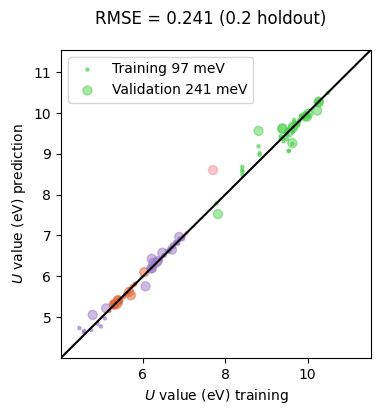

In [79]:
def rmse(y1, y2):
    return np.sqrt(((y1 - y2) ** 2).mean())


df_validate = df.loc[validate_idx]
validate_rmse = hubbardml.datasets.rmse(df_validate)
plots.create_parity_plot(df, title=f'RMSE = {validate_rmse:.3f} ({VALIDATE_PERCENTAGE} holdout)',
                         axis_label=f'${TARGET_PARAM}$ value (eV)');

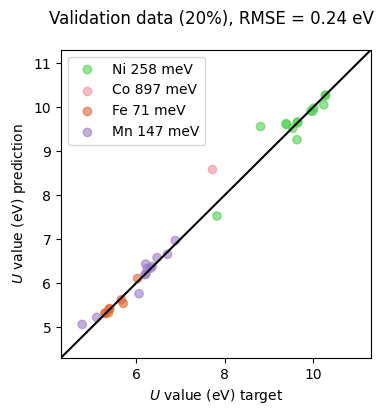

In [80]:
fig = plots.split_plot(df_validate, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

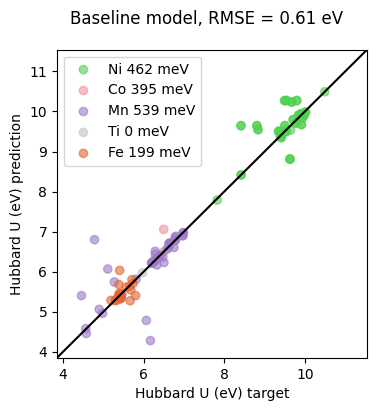

In [81]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(df_ref, keys.ATOM_1_ELEMENT, axis_label=f'Hubbard {TARGET_PARAM} (eV)',
                       title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref):.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

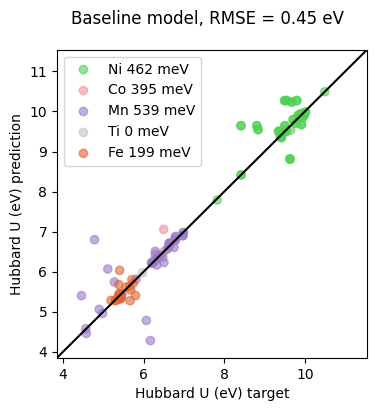

In [82]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(
    df_ref,
    keys.ATOM_1_ELEMENT,
    axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref, label="both"):.2f} eV',
);

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

In [83]:
{str(pathlib.Path(directory).parent) for directory in df[keys.DIR].unique()}

{'/Users/azadoks/Data/uv_ml/iurii/Layered/1_LixCoO2/1_CoO2_DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/1_LixCoO2/1_LiCoO2_DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/2_LixNiO2/1_LiNiO2_DFT_plus_UV_v3',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/2_LixNiO2/1_NiO2_DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/3_LixMnO2/3_LiMnO2_DFT_plus_UV_v3',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/3_LixMnO2/3_MnO2_DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/4_LixTiS2/4_LiTiS2_DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Layered/4_LixTiS2/4_TiS2_DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0.5Mn0.5PO4/A1_Li0.00Mn0.5Fe0.5PO4/DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFePO4/C1_Li0.00FePO4/DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFePO4/C2_Li0.25FePO4/DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFePO4/C3_Li0.50FePO4/DFT_plus_UV',
 '/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFePO4/C4_Li0.75FePO4/

In [84]:
max_range = df[keys.PARAM_OUT].max() - df[keys.PARAM_OUT].min()
max_range = max(max_range, (df[keys.PARAM_OUT_PREDICTED].max() - df[keys.PARAM_OUT_PREDICTED].min()))
print(max_range)

plots.create_progression_plots(
    df,
    '/home/azadoks/Projects/uv_ml/data/iurii/Olivines/LiMnPO4/B2_Li0.25MnPO4/DFT_plus_UV',
    yrange=1.2
);

6.0374


TypeError: create_progression_plots() got multiple values for argument 'yrange'

In [ ]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_u/steps_{idx}_+U.pdf', bbox_inches='tight')
            idx += 1

In [ ]:
import copy

fig, ax = copy.deepcopy(model.tp1).cpu().visualize()
# ax.get_lines()[0].set_color('black')
for patch in ax.patches:
    patch.set_color(plots.plot_colours[2])

if SAVEFIGS:
    fig.savefig('plots/hubbard_u_tp.pdf', bbox_inches='tight')

In [ ]:
df[df[keys.PARAM_IN] == 0.][keys.TRAINING_LABEL]
